In [1]:
import numpy as np
import pandas as pd

# Retrieve POIs data
import requests
import json

# Geospatial analysis: spatial join, aggregate, buffer
import geopandas as gpd

# Walkshed with road network
import osmnx as ox
import networkx as nx
from shapely.geometry import Point
from alphashape import alphashape

# Plotting
import folium
import matplotlib
import matplotlib.pyplot as plt

/home/liaom/sc/cdm_envs/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Reprojection: Geographical V.S. Projected Coordinate Systems
* Commonly-used Coordinate System for D.C.:
    * https://octo.dc.gov/page/coordinate-system-standards
    * https://epsg.io/6487

In [2]:
# read census tract boundary in DC
dc_census_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_11_tract.zip")

In [3]:
# Check the coordinate system of `dc_census_tract`
dc_census_tract.crs 

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [4]:
# Reproject the D.C. boundary data to the projected coordinate system "MD State Plane NAD 83"
dc_census_tract_rprj = dc_census_tract.to_crs("EPSG:6487")

In [5]:
dc_census_tract_rprj.crs 

<Derived Projected CRS: EPSG:6487>
Name: NAD83(2011) / Maryland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Maryland - counties of Allegany; Anne Arundel; Baltimore; Calvert; Caroline; Carroll; Cecil; Charles; Dorchester; Frederick; Garrett; Harford; Howard; Kent; Montgomery; Prince Georges; Queen Annes; Somerset; St Marys; Talbot; Washington; Wicomico; Worcester.
- bounds: (-79.49, 37.97, -74.97, 39.73)
Coordinate Operation:
- name: SPCS83 Maryland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

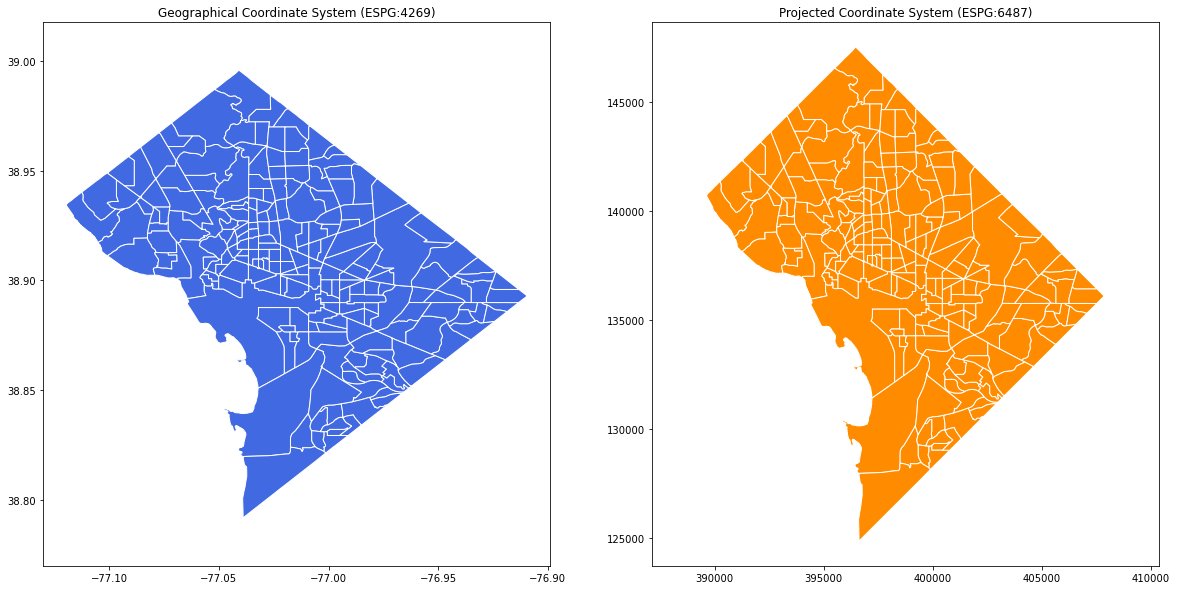

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the original coordinate system
dc_census_tract.plot(ax=ax1, color='royalblue', edgecolor='white')
ax1.set_title('Geographical Coordinate System (ESPG:4269)')
ax1.axis('equal')

# Plot the reprojected coordinate system
dc_census_tract_rprj.plot(ax=ax2, color='darkorange', edgecolor='white')
ax2.set_title('Projected Coordinate System (ESPG:6487)')
ax2.axis('equal')

plt.show()

In [7]:
# Eateries in D.C.

## Retrive POIs in D.C.

In [8]:
# Get the bounding box of D.C.
print(dc_census_tract.total_bounds)

[-77.119759  38.791645 -76.909393  38.995845]


In [9]:
# Define the bboxing of Washington, D.C. for POIs query using overpass API
dc_bbox = "38.791645, -77.119759, 38.995845, -76.909393"

In [10]:
# Define the Overpass API URL
overpass_url = "http://overpass-api.de/api/interpreter"

# Define the Overpass query using the bounding box variable
dc_eatery_overpass_query = f"""
[out:json][timeout:25];

(
  node["amenity"="restaurant"]({dc_bbox});
  node["amenity"="cafe"]({dc_bbox});
  node["amenity"="bar"]({dc_bbox});
  node["amenity"="biergarten"]({dc_bbox});
  node["amenity"="pub"]({dc_bbox});
  
);
out body;
>;
out skel qt;
"""

# Make the request
dc_eatery_response = requests.get(overpass_url, params={'data': dc_eatery_overpass_query})
dc_eatery_dict = dc_eatery_response.json()

# Convert the data into a pandas DataFrame
dc_eatery_list = [] # Create a list for the initilization of the dataframe
for element in dc_eatery_dict['elements']:
    uid = element['id'] 
    latitude = element['lat']
    longitude = element['lon']
    name = element.get('tags', {}).get('name', 'n/a')
    amenity = element.get('tags', {}).get('amenity', 'n/a')
    dc_eatery_list.append({
        'UID': uid,
        'Name': name,
        'Type': amenity,
        'Latitude': latitude,
        'Longitude': longitude
    })

# Create the DataFrame using the list
dc_eatery_df = pd.DataFrame(dc_eatery_list)

# Show the DataFrame
dc_eatery_df

UID                Name        Type   Latitude  Longitude
0        60471261       Cafe Saint Ex         bar  38.915421 -77.031701
1       388247153            Millie’s  restaurant  38.945050 -77.096330
2       419267705       Buzz Bakeshop        cafe  38.821596 -77.047646
3       459806171         Euro Market        cafe  38.891441 -77.086067
4       460211089         Mamma Lucia  restaurant  38.990991 -77.029690
...           ...                 ...         ...        ...        ...
2291  11327854132          Donahue DC  restaurant  38.907631 -77.063620
2292  11327854133  Georgetown Seafood  restaurant  38.905525 -77.065083
2293  11327854139            Gong Cha        cafe  38.905273 -77.065405
2294  11329577820       Officina Cafe        cafe  38.903914 -77.037518
2295  11333728035                 n/a  restaurant  38.883767 -77.024932

[2296 rows x 5 columns]

## Aggregate POIs into Each Census Tract in D.C.

In [11]:
# Create a GeoDataFrame for `dc_eatery_df`
dc_eatery_gdf = gpd.GeoDataFrame(dc_eatery_df.copy(), geometry=gpd.points_from_xy(dc_eatery_df.Longitude, dc_eatery_df.Latitude), crs = dc_census_tract.crs) 

# Reproject the `dc_eatery_gdf` to match the CRS of the `dc_census_tract_rprj` GeoDataFrame
dc_eatery_gdf_rprj = dc_eatery_gdf.to_crs(dc_census_tract_rprj.crs)

# Perform a spatial join between the reprojected eatery points and the census tracts.
# This assigns each eatery to a census tract if it is within the tract's boundaries.
dc_eatery = gpd.sjoin(dc_eatery_gdf_rprj, dc_census_tract_rprj, predicate='within', how='inner').reset_index(drop = True)
dc_ct_eatery = dc_eatery.assign(count = np.ones(dc_eatery.shape[0]))
dc_ct_eatery = dc_ct_eatery.groupby('GEOID')['count'].sum().reset_index()

# Merge the eatery counts with the census tracts GeoDataFrame
dc_ct_eatery = dc_census_tract_rprj.merge(dc_ct_eatery, on='GEOID', how='left')

# Replace NaN values with 0 for tracts without eatery
dc_ct_eatery['count'] = dc_ct_eatery['count'].fillna(0)

# Rename the 'count' column to 'eatery_count'
dc_ct_eatery.rename(columns={'count': 'eatery_count'}, inplace=True)

<AxesSubplot:>

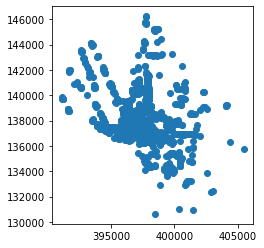

In [12]:
dc_eatery.plot()

## Density of Eateries by Census Tracts

In [13]:
# Calculate the area of each census tract in D.C.
dc_ct_eatery = dc_ct_eatery.assign(area_km2 = dc_ct_eatery.geometry.area/1e6)

In [14]:
dc_ct_eatery = dc_ct_eatery.assign(eatery_density = dc_ct_eatery.eatery_count/dc_ct_eatery.area_km2)

### Visualization

In [15]:
dc_ct_eatery_geog = dc_ct_eatery.to_crs(dc_census_tract.crs)
dc_eatery_geog = dc_eatery.to_crs(dc_census_tract.crs)

# Create a colormap and normalizer for the unique types of eateries
unique_types = dc_eatery_geog.Type.unique()
cmap = matplotlib.cm.get_cmap('tab10', len(unique_types))  # 'tab10' is a good discrete colormap for categorical data
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(unique_types) - 1)

# Initialize the map centered around Washington D.C.
m = folium.Map(location=[38.9072, -77.0369], zoom_start=12, tiles='CartoDB Positron')

# Add the census tracts to the map with color based on 'eatery_density'
folium.Choropleth(
    geo_data=dc_ct_eatery_geog.to_json(),
    name='Census Tracts',
    data=dc_ct_eatery_geog,
    columns=['GEOID', 'eatery_density'],  
    key_on='feature.properties.GEOID',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Eatery Density by Census Tracts'
).add_to(m)

# Create a feature group for each unique type of eatery
feature_groups = {}
for eatery_type in unique_types:
    feature_group = folium.FeatureGroup(name=str(eatery_type))
    feature_groups[eatery_type] = feature_group
    feature_group.add_to(m)

# Add the eateries to their respective feature group
for _, row in dc_eatery_geog.iterrows():
    eatery_type = row['Type']
    color = matplotlib.colors.to_hex(cmap(norm(unique_types.tolist().index(eatery_type))))
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        color=color,
        radius=1.5,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(feature_groups[eatery_type])

# Add the layer control to toggle feature groups
folium.LayerControl().add_to(m)

# Display the map
m.save('DC_Eateries_and_Census_Tracts.html')
m  # If you're using a Jupyter notebook, this will display the map inline.


# Walkshed

## Retrieve Metro Stations Data 
* Data Source: https://opendata.dc.gov/explore?collection=Dataset&query=WMATA
* Walkshed radius: https://www.mwcog.org/newsroom/2019/07/16/walksheds-show-planners-how-easily-people-can-walk-to-transit/

In [16]:
dc_station_url = "https://opendata.dc.gov/datasets/54018b7f06b943f2af278bbe415df1de_52.geojson"

# Read the data into a GeoDataFrame
dc_station_gdf = gpd.read_file(dc_station_url)

# Reproject
dc_station_gdf_rprj = dc_station_gdf.to_crs(dc_census_tract_rprj.crs)

# Remove the stations outside the boundary of D.C.
dc_station_gdf_rprj = gpd.clip(dc_station_gdf_rprj, dc_census_tract_rprj)

<AxesSubplot:>

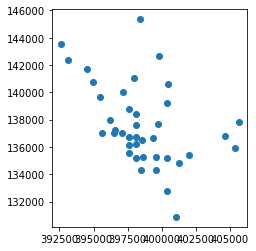

In [17]:
dc_station_gdf_rprj.plot()

## Create Walksheds Using Simple Buffer

In [18]:
# Set Buffer Raidus
buffer_distance = 804.67 # Half a mile is 804.67 metres.

# Create the buffer around each point to get a GeoSeries of buffered geometries
walksheds_simple_buffer = dc_station_gdf_rprj.geometry.buffer(buffer_distance)

# Create a new GeoDataFrame from the buffered geometries
walkshed_sb_gdf = gpd.GeoDataFrame(geometry=walksheds_simple_buffer)

# If you want to retain the original data from 'dc_station_gdf_rprj', you can join it with the new GeoDataFrame
walkshed_sb_gdf = walkshed_sb_gdf.join(dc_station_gdf_rprj.drop(columns='geometry'))

<AxesSubplot:>

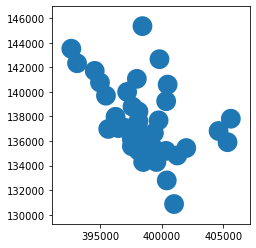

In [19]:
walkshed_sb_gdf.plot()

### Q1: How many eateries in each walkshed? 

In [20]:
dc_walkshed_sb_eatery = gpd.sjoin(dc_eatery_gdf_rprj, walkshed_sb_gdf, predicate='within', how='inner').reset_index(drop = True)
dc_walkshed_sb_eatery = dc_walkshed_sb_eatery.assign(eatery_count = np.ones(dc_walkshed_sb_eatery.shape[0]))
dc_walkshed_sb_eatery = dc_walkshed_sb_eatery.groupby('GIS_ID')['eatery_count'].sum().reset_index()

# Merge the eatery counts with the walkshed_sb GeoDataFrame
dc_walkshed_sb_eatery = walkshed_sb_gdf.merge(dc_walkshed_sb_eatery, on='GIS_ID', how='left')

# Replace NaN values with 0 for tracts without eatery
dc_walkshed_sb_eatery['eatery_count'] = dc_walkshed_sb_eatery['eatery_count'].fillna(0)

#### Visualization

In [21]:
dc_ct_eatery_geog = dc_ct_eatery.to_crs(dc_census_tract.crs)
dc_eatery_geog = dc_eatery.to_crs(dc_census_tract.crs)
dc_walkshed_sb_eatery_geog = dc_walkshed_sb_eatery.to_crs(dc_census_tract.crs)

# Create a colormap and normalizer for the unique types of eateries
unique_types = dc_eatery_geog.Type.unique()
cmap = matplotlib.cm.get_cmap('tab10', len(unique_types))  # 'tab10' is a good discrete colormap for categorical data
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(unique_types) - 1)

# Initialize the map centered around Washington D.C.
m = folium.Map(location=[38.9072, -77.0369], zoom_start=12, tiles='CartoDB Positron')

# Add the census tracts to the map with color based on 'eatery_density'
folium.Choropleth(
    geo_data=dc_ct_eatery_geog.to_json(),
    name='Census Tracts',
    data=dc_ct_eatery_geog,
    columns=['GEOID', 'eatery_density'],  
    key_on='feature.properties.GEOID',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Eatery Density by Census Tracts'
).add_to(m)

# Add the walksheds to the map
folium.Choropleth(
    geo_data=dc_walkshed_sb_eatery_geog.to_json(),
    name='Walkshed with Simple Buffer',
    data=dc_walkshed_sb_eatery_geog,
    columns=['GIS_ID', 'eatery_count'],  
    key_on='feature.properties.GIS_ID',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Eatery Counts by Walksheds'
).add_to(m)

# Create a feature group for each unique type of eatery
feature_groups = {}
for eatery_type in unique_types:
    feature_group = folium.FeatureGroup(name=str(eatery_type))
    feature_groups[eatery_type] = feature_group
    feature_group.add_to(m)

# Add the eateries to their respective feature group
for _, row in dc_eatery_geog.iterrows():
    eatery_type = row['Type']
    color = matplotlib.colors.to_hex(cmap(norm(unique_types.tolist().index(eatery_type))))
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        color=color,
        radius=1.5,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(feature_groups[eatery_type])

# Add the layer control to toggle feature groups
folium.LayerControl().add_to(m)

# Display the map
m.save('DC_Eateries_and_Walksheds_Simple_Buffer.html')
m  # If you're using a Jupyter notebook, this will display the map inline.


### Q2:Which eatery is located within the highest number of station walksheds?

In [22]:
# Perform the spatial join
joined_gdf = gpd.sjoin(dc_eatery_gdf_rprj, walkshed_sb_gdf, predicate='within', how='left').reset_index(drop = True)

# Count the number of walksheds each eatery is within
eatery_walkshed_counts = joined_gdf.groupby('UID').size()  

# Find the eatery with the highest count
most_walksheds = eatery_walkshed_counts.idxmax()
highest_count = eatery_walkshed_counts.max()

# Get the details of the eatery with the most walksheds
eatery_with_most_walksheds = dc_eatery_gdf_rprj.loc[dc_eatery_gdf_rprj['UID'] == most_walksheds]

print(f"The eatery with the most walksheds is: {(eatery_with_most_walksheds.Name.values)}")
print(f"Number of walksheds: {highest_count}")


The eatery with the most walksheds is: ['Oya Restaurant & Lounge']
Number of walksheds: 6


## Create Walksheds With Road Network

In [23]:
from datetime import datetime
# Define the walking distance in meters
walking_distance_metres = 804.67 # Half a mile is 804.67 metres.
alpha = 300

# Initialize an empty list to hold the walkshed polygons
walkshed_as = []

# Loop through each station to calculate walksheds
# It would take no more than 5 mins
for index, station in dc_station_gdf.iterrows():
    # Get the x and y coordinates of the station
    x, y = station.geometry.x, station.geometry.y
    
    # Create the network graph around the station
    G = ox.graph_from_point((y, x), dist=walking_distance_metres, dist_type='network', network_type='walk')
    
    # Find the node in the graph that's closest to the station
    G_proj = ox.project_graph(G)
    center_node = ox.distance.nearest_nodes(G_proj, x, y)
    
    # Create a subgraph within the walking distance
    subgraph = nx.ego_graph(G_proj, center_node, radius=walking_distance_metres, distance='length')
    
    # Use the nodes from the subgraph to create an alphashape polygon
    node_points = [(data["lon"], data["lat"]) for node, data in subgraph.nodes(data=True)]
    if len(node_points) > 3:  # alphashape requires at least 4 points to compute a shape
        alpha_shape = alphashape(node_points, alpha=alpha)
        walkshed_as.append(gpd.GeoDataFrame([[station['GIS_ID'], alpha_shape]], columns=['GIS_ID', 'geometry']))
        
# Combine all walkshed polygons into a single GeoDataFrame
walkshed_as_gdf = gpd.GeoDataFrame(pd.concat(walkshed_as, ignore_index=True)).set_crs("EPSG:4326")    
end = datetime.now()

<AxesSubplot:>

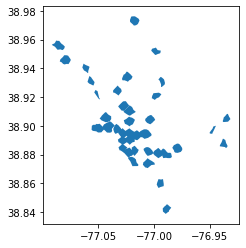

In [24]:
walkshed_as_gdf.plot()

### Exercie 1: How many eateries in each walkshed? 

In [25]:
walkshed_as_gdf_rprj = walkshed_as_gdf.to_crs(dc_census_tract_rprj.crs)
dc_walkshed_as_eatery = gpd.sjoin(dc_eatery_gdf_rprj, walkshed_as_gdf_rprj, predicate='within', how='inner').reset_index(drop = True)
dc_walkshed_as_eatery = dc_walkshed_as_eatery.assign(eatery_count = np.ones(dc_walkshed_as_eatery.shape[0]))
dc_walkshed_as_eatery = dc_walkshed_as_eatery.groupby('GIS_ID')['eatery_count'].sum().reset_index()

# Merge the eatery counts with the census tracts GeoDataFrame
dc_walkshed_as_eatery = walkshed_as_gdf.merge(dc_walkshed_as_eatery, on='GIS_ID', how='left')

# Replace NaN values with 0 for tracts without eatery
dc_walkshed_as_eatery['station_count'] = dc_walkshed_as_eatery['eatery_count'].fillna(0)

#### Visualization

In [26]:
dc_ct_eatery_geog = dc_ct_eatery.to_crs(dc_census_tract.crs)
dc_eatery_geog = dc_eatery.to_crs(dc_census_tract.crs)
dc_walkshed_as_eatery_geog = dc_walkshed_as_eatery.to_crs(dc_census_tract.crs)
# Create a colormap and normalizer for the unique types of eateries
unique_types = dc_eatery_geog.Type.unique()
cmap = matplotlib.cm.get_cmap('tab10', len(unique_types))  # 'tab10' is a good discrete colormap for categorical data
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(unique_types) - 1)

# Initialize the map centered around Washington D.C.
m = folium.Map(location=[38.9072, -77.0369], zoom_start=12, tiles='CartoDB Positron')

# Add the census tracts to the map with color based on 'eatery_density'
folium.Choropleth(
    geo_data=dc_ct_eatery_geog.to_json(),
    name='Census Tracts',
    data=dc_ct_eatery_geog,
    columns=['GEOID', 'eatery_density'],  
    key_on='feature.properties.GEOID',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Eatery Density by Census Tracts'
).add_to(m)

# Add the walksheds to the map
folium.Choropleth(
    geo_data=dc_walkshed_as_eatery_geog.to_json(),
    name='Walkshed with alphashape',
    data=dc_walkshed_as_eatery_geog,
    columns=['GIS_ID', 'eatery_count'],  
    key_on='feature.properties.GIS_ID',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Eatery Counts by Walksheds'
).add_to(m)

# Create a feature group for each unique type of eatery
feature_groups = {}
for eatery_type in unique_types:
    feature_group = folium.FeatureGroup(name=str(eatery_type))
    feature_groups[eatery_type] = feature_group
    feature_group.add_to(m)

# Add the eateries to their respective feature group
for _, row in dc_eatery_geog.iterrows():
    eatery_type = row['Type']
    color = matplotlib.colors.to_hex(cmap(norm(unique_types.tolist().index(eatery_type))))
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        color=color,
        radius=1.5,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(feature_groups[eatery_type])

# Add the layer control to toggle feature groups
folium.LayerControl().add_to(m)

# Display the map
m.save('DC_Eateries_and_Walksheds_alphashape.html')
m  # If you're using a Jupyter notebook, this will display the map inline.


### Exercise 2: Which eatery is located within the highest number of station walkshed?

In [27]:
# Perform the spatial join
joined_gdf = gpd.sjoin(dc_eatery_gdf_rprj, walkshed_as_gdf_rprj, predicate='within', how='left').reset_index(drop = True)

# Count the number of walksheds each eatery is within
eatery_walkshed_counts = joined_gdf.groupby('UID').size()  # Replace 'eatery_id' with the appropriate identifier for eateries

# Find the eatery with the highest count
most_walksheds = eatery_walkshed_counts.idxmax()
highest_count = eatery_walkshed_counts.max()

# Get the details of the eatery with the most walksheds
eatery_with_most_walksheds = dc_eatery_gdf_rprj.loc[dc_eatery_gdf_rprj['UID'] == most_walksheds]

print(f"The eatery with the most walksheds is: {(eatery_with_most_walksheds.Name.values)}")
print(f"Number of walksheds: {highest_count}")


The eatery with the most walksheds is: ['Avenue Grill']
Number of walksheds: 2
